# **Dobra, jakis tytul trzeba tu wymyślić** #

## **1. Basic imports** ##

In [2]:
import numpy as np
import pandas as pd
from enum import Enum
from abc import ABC, abstractmethod

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from scipy.stats import ks_2samp, wasserstein_distance, spearmanr, anderson_ksamp
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon, cdist

from pyclustering.cluster.xmeans import xmeans, kmeans_plusplus_initializer # type: ignore

from river.datasets import synth
from river.drift import ADWIN
from river import evaluate, metrics, ensemble, drift, tree

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
import warnings

if not hasattr(np, "warnings"):
    np.warnings = warnings

## **2. Creating concept drift stream** ##

### **2.1. Different Concept Drift Generators** ###

#### **2.1.1. SEA** ####

Ten generator jest fajny, ale trzeba zmienić variant zeby były rózne. Inaczej wygeneują się dwa niemal identyczne strumienie.

In [4]:
stream_SEA = synth.ConceptDriftStream(
    stream=synth.SEA(seed=42, variant=0),
    drift_stream=synth.SEA(seed=42, variant=3),
    position=500,
    width=10,
    seed=1
)

#### **2.1.2. Hyperplane** ####

In [5]:
# stream_Hyperplane = synth.ConceptDriftStream(
#     stream=synth.Hyperplane(n_features=2, seed=42),
#     drift_stream=synth.Hyperplane(n_features=2,noise_percentage=0.0, mag_change=0.01, seed=42),
#     position=500,
#     width=100,
#     seed=1
# )

In [6]:
stream_Hyperplane = synth.Hyperplane(
    n_features=2,
    noise_percentage=0.0,
    mag_change=0.01,
    seed=42
)

#### **2.1.3. RandomRBF** ####

To jest trochę crazy i coś tam coś tam ze jakies centroidy, ale nie wygląda to tak ładnie jak SEA

In [7]:

stream_RBF = synth.ConceptDriftStream(
    stream=synth.RandomRBF(n_features=2),
    drift_stream=synth.RandomRBF(n_features=2),
    position=500,
    width=10,
    seed=1
)

### **2.2. Visualization of data drift** ###

In [8]:
def visualize_drift(stream, n):
    """
    Visualizes the data points before and after a concept drift in a 2D feature space.

    Parameters:
    - stream: A data stream object that yields (features, label) tuples.
    - n: Total number of samples to take from the stream for visualization. Drift starts at n/2.
    """
    X, y = [], []
    for x, label in stream.take(n):
        X.append(x)
        y.append(label)

    # Convert to lists of features
    f1 = [row[0] for row in X]
    f2 = [row[1] for row in X]

    # Plot before and after drift
    plt.figure(figsize=(12, 5))

    # Before drift
    plt.subplot(1, 2, 1)
    plt.scatter(f1[:n//2], f2[:n//2], c=y[:n//2], cmap="coolwarm", s=20, alpha=0.7)
    plt.title("Before Drift")
    plt.xlabel("att0")
    plt.ylabel("att1")

    # After drift
    plt.subplot(1, 2, 2)
    plt.scatter(f1[n//2:], f2[n//2:], c=y[n//2:], cmap="coolwarm", s=20, alpha=0.7)
    plt.title("After Drift")
    plt.xlabel("att0")
    plt.ylabel("att1")

    plt.tight_layout()
    plt.show()

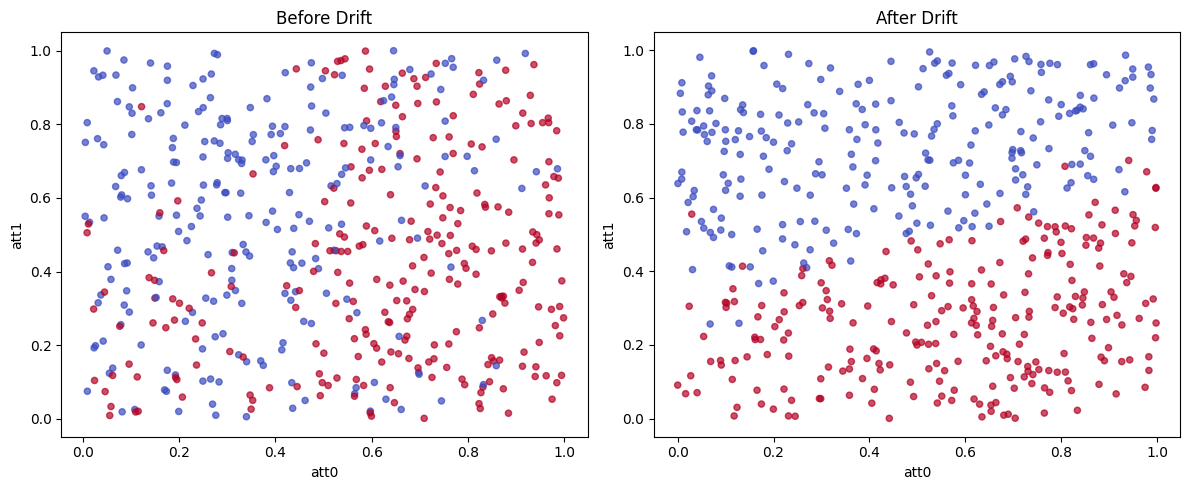

In [9]:
visualize_drift(stream_Hyperplane, 1000)

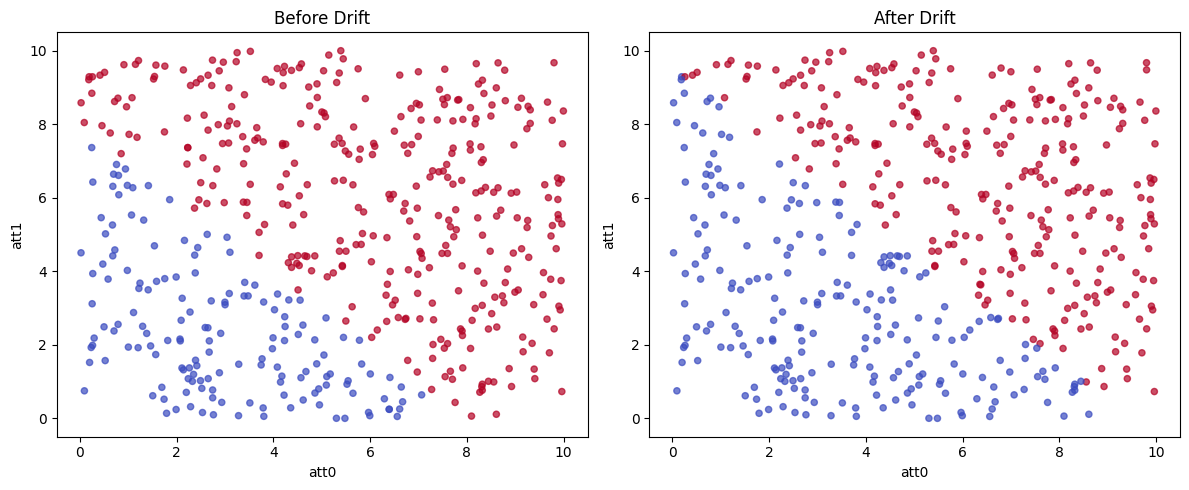

In [10]:
visualize_drift(stream_SEA, 1000)

## **3. Data scaling + other helpers**

### **3.1. Data normalization** ##

May be necessary later

In [11]:
class ScalingType(Enum):
    MinMax = 'min_max'
    Standardization = 'standardization'

def transform_dict_to_list(stream, n_samples=1000):
    X, y = [], []
    for x, label in stream.take(n_samples):
        X.append(list(x.values()))
        y.append(label)
    return X, y

class DataScaler:
    def __init__(self, scaling_type):
        if scaling_type==ScalingType.MinMax:
            self.scaler = MinMaxScaler()
        elif scaling_type==ScalingType.Standardization:
            self.scaler = StandardScaler()
        else:
            raise ValueError("Unsupported scaling type")

    def fit(self, X):
        X_df = pd.DataFrame(X)
        self.scaler.fit(X_df)
        
    def transform(self, X): # one scaler can be fitted once but used many times
        X_df = pd.DataFrame(X)
        return self.scaler.transform(X_df)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [12]:
X, y = transform_dict_to_list(stream_SEA, 1000)
X_before, X_after = X[:500], X[500:]
y_before, y_after = y[:500], y[500:]

data_scaler = DataScaler(ScalingType.Standardization)
X_before_scaled = data_scaler.fit_transform(X_before)
X_after_scaled = data_scaler.transform(X_after)

### **3.2. Data dimensions reducer for plotting multidimensional data**
For plotting purposes

In [13]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.decomposition import FastICA, FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from umap import UMAP


class ReducerType(Enum):
    # For linear data
    PCA = 'PCA'
    ICA = 'ICA'
    FA = 'FA'
    LDA = 'LDA'

    # Non-linear
    TSNE = 't_SNE'
    UMAP = 'UMAP'
    LLE = 'LLE'
    MDS = 'MDS'
    # Autoencoders/Isomap/kernel PCA could be added here

class DataDimensionsReducer:
    def __init__(self):
        self.reducer = None

    def reduce(self, reducer_type, data):
        return getattr(self, f"reduce_{reducer_type.value}")(data)
    
    def _reduce(self, data, reducer):
        if self.reducer is not None:
            reduced_data = self.reducer.transform(data)
        else:
            self.reducer = reducer
            reduced_data = self.reducer.fit_transform(data)
        return reduced_data

    def reduce_PCA(self, data):
        return self._reduce(data, PCA(n_components=2))

    def reduce_ICA(self, data):
        return self._reduce(data, FastICA(n_components=2))

    def reduce_FA(self, data):
        return self._reduce(data, FactorAnalysis(n_components=2))

    def reduce_LDA(self, data):
        return self._reduce(data, LDA(n_components=2))

    def reduce_t_SNE(self, data):
        return self._reduce(data, TSNE(n_components=2))

    def reduce_UMAP(self, data):
        return self._reduce(data, UMAP(n_components=2))

    def reduce_LLE(self, data):
        return self._reduce(data, LocallyLinearEmbedding(n_components=2, n_neighbors=15))

    def reduce_MDS(self, data):
        return self._reduce(data, MDS(n_components=2))

In [14]:
drift_10d = synth.ConceptDriftStream(
    stream=synth.Hyperplane(n_features=10, seed=42),
    drift_stream=synth.Hyperplane(n_features=10, seed=42),
    position=500,
    width=10,
    seed=1
)
X_10d, y = transform_dict_to_list(drift_10d, 1000)
X_2d = DataDimensionsReducer().reduce(ReducerType.PCA, X_10d)

### **3.3. Data plotting** ###

In [15]:
def plot_data(X, y, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=20, alpha=0.7)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

def plot_drift(X_before, y_before, X_after, y_after, show = True, in_subplot=False):
    plt.figure(figsize=(12, 5))

    # Before drift
    plt.subplot(1, 2, 1)
    plt.scatter(X_before[:, 0], X_before[:, 1], c=y_before, cmap="coolwarm", s=20, alpha=0.7)
    plt.title('Before')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # After drift
    plt.subplot(1, 2, 2)
    plt.scatter(X_after[:, 0], X_after[:, 1], c=y_after, cmap="coolwarm", s=20, alpha=0.7)
    plt.title('After')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    plt.tight_layout()
    plt.show()

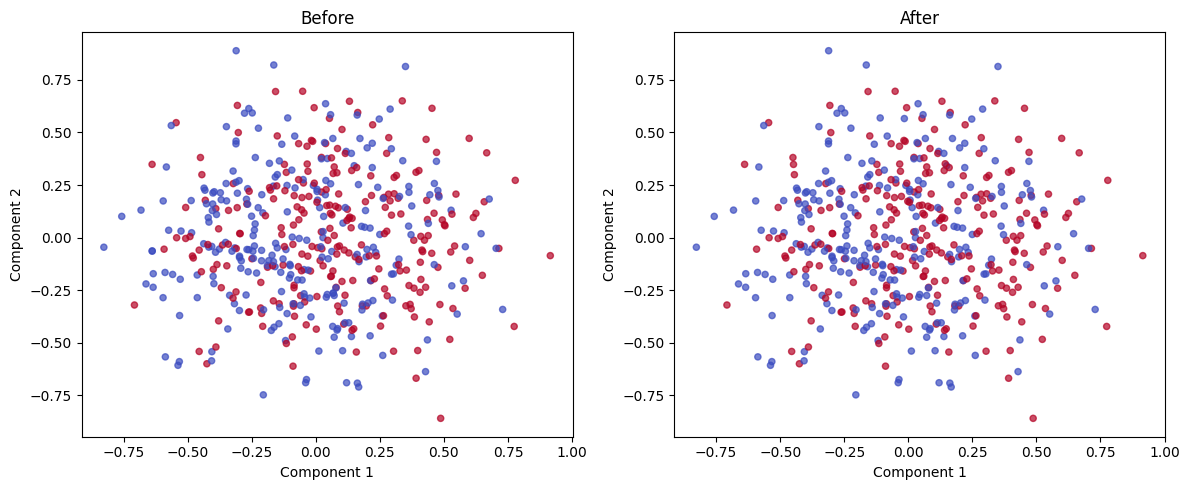

In [16]:
plot_drift(X_2d[:500], y[:500], X_2d[500:], y[500:])

## **4. Drift detection using descriptive statistics**

In [17]:
class StatisticsType(Enum):
    Mean = 'mean'
    StandardDeviation = 'sd'
    Min = 'min'
    Max = 'max'
    Median = 'median'
    ImbalanceRatio = 'imbalance_ratio'
    All = 'all' # TODO: implement all

class DriftDetector(ABC):
    def detect(self):
        pass

class DescriptiveStatisticsDriftDetector(DriftDetector):
    def __init__(self):
        pass

    def calculate_range(self, old_value, new_value, thr):
        if old_value == 0 and new_value == 0:
            return False
        elif old_value == 0 and new_value != 0:
            return True
        elif abs(new_value - old_value)/abs(old_value) > thr:
            return True
        return False

    def detect_mean(self, old_data, new_data, thr):
        old_mean = old_data.groupby('label').mean().T
        new_mean = new_data.groupby('label').mean().T

        assert old_mean.shape == new_mean.shape
        for label in old_mean.columns:
            for feature in old_mean.index:
                if self.calculate_range(old_mean.at[feature, label], new_mean.at[feature, label], thr):
                    return True
        return False

    def detect_median(self, old_series, new_series, thr):
        old_median = old_series.groupby('label').median().T
        new_median = new_series.groupby('label').median().T
        
        assert old_median.shape == new_median.shape
        for label in old_median.columns:
            for feature in old_median.index:
                if self.calculate_range(old_median.at[feature, label], new_median.at[feature, label], thr):
                    return True
        return False

    def detect_sd(self, old_data, new_data, thr):
        old_sd = old_data.groupby('label').std().T
        new_sd = new_data.groupby('label').std().T

        assert old_sd.shape == new_sd.shape
        for label in old_sd.columns:
            for feature in old_sd.index:
                if self.calculate_range(old_sd.at[feature, label], old_sd.at[feature, label], thr):
                    return True
        return False

    def detect_min(self, old_data, new_data, thr):
        old_min = old_data.groupby('label').min().T
        new_min = new_data.groupby('label').min().T
        
        assert old_min.shape == new_min.shape
        for label in old_min.columns:
            for feature in old_min.index:
                if self.calculate_range(old_min.at[feature, label], new_min.at[feature, label], thr):
                    return True
        return False

    def detect_max(self, old_data, new_data, thr):
        old_max = old_data.groupby('label').max().T
        new_max = new_data.groupby('label').max().T
        
        assert old_max.shape == new_max.shape
        for label in old_max.columns:
            for feature in old_max.index:
                if self.calculate_range(old_max.at[feature, label], new_max.at[feature, label], thr):
                    return True
        return False
    
    def detect_imbalance_ratio(self, old_data, new_data, thr):
        old_ir = old_data['label'].value_counts(normalize=True)
        new_ir = new_data['label'].value_counts(normalize=True)

        assert old_ir.shape == new_ir.shape
        for label in old_ir.index:
            if self.calculate_range(old_ir.at[label], new_ir.at[label], thr):
                return True
        return False
    
    def _detect_single_statistic(self, old_data, new_data, stat_type, thr):
        if stat_type == StatisticsType.Mean:
            return self.detect_mean(old_data, new_data, thr)
        elif stat_type == StatisticsType.StandardDeviation:
            return self.detect_sd(old_data, new_data, thr)
        elif stat_type == StatisticsType.Min:
            return self.detect_min(old_data, new_data, thr)
        elif stat_type == StatisticsType.Max:
            return self.detect_max(old_data, new_data, thr)
        elif stat_type == StatisticsType.Median:
            return self.detect_median(old_data, new_data, thr)
        elif stat_type == StatisticsType.ImbalanceRatio:
            return self.detect_imbalance_ratio(old_data, new_data, thr)
        else:
            raise ValueError("Unsupported statistics type")

    def detect(self, old_data, new_data, stat_type, features=None, thr=0.2):
        if features is not None:
            old_data = old_data[features]
            new_data = new_data[features]

        if type(stat_type) is list:
            drifts = []
            for st in stat_type:
                drifts.append(self._detect_single_statistic(old_data, new_data, st, thr))
            return sum(drifts)/len(drifts) > 0.4
        else:
            return self._detect_single_statistic(old_data, new_data, stat_type, thr)

In [18]:
def transform_lists_to_df(X, y):
    X_df = pd.DataFrame(X)
    y_series = pd.Series(y)
    data = pd.concat([X_df, y_series], axis=1)
    data.columns = [f'feature{i}' for i in range(X_df.shape[1])] + ['label']
    return data

In [19]:
data_before = transform_lists_to_df(X_before, y_before)
data_after = transform_lists_to_df(X_after, y_after)

DSDD = DescriptiveStatisticsDriftDetector()
print(DSDD.detect(data_before, data_after, StatisticsType.Mean))
print(DSDD.detect(data_before, data_after, StatisticsType.Min))
print(DSDD.detect(data_before, data_after, StatisticsType.Max))
print(DSDD.detect(data_before, data_after, StatisticsType.Median))
print(DSDD.detect(data_before, data_after, StatisticsType.StandardDeviation))
print(DSDD.detect(data_before, data_after, StatisticsType.ImbalanceRatio))
print(DSDD.detect(data_before, data_after, [
    StatisticsType.Mean,
    StatisticsType.Min,
    StatisticsType.Max,
    StatisticsType.Median,
    StatisticsType.StandardDeviation,
    StatisticsType.ImbalanceRatio
]))

True
True
True
False
False
True
True


## **5. Drift detection using statistical tests**

In [20]:
class StatisticalTestType(Enum):
    KolmogorovSmirnov = 'kolmogorov_smirnov_test'
    KullbackLeibler = 'kullback_leibler_divergence'
    WassersteinDistance = 'wasserstein_distance'
    JensenShannon = 'jensen_shannon_divergence'
    Spearman = 'spearman_correlation_coefficient'
    AD = 'ad'
    CHI2 = 'chi2'

class StatisticalTestsDriftDetector(DriftDetector):
    def __init__(self):
        pass

    def detect_kolmogorov_smirnov(self, old_data, new_data, alpha=0.05):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                stat, p_value = ks_2samp(old_data[old_data.label == l][column], new_data[new_data.label == l][column])
                if p_value < alpha:
                    return True
        return False

    def detect_kullback_leibler(self, old_data, new_data, thr=0.1, bins=30):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                old_dist = np.histogram(old_data[old_data.label == l][column], bins=bins, density=True)[0] + 1e-10
                new_dist = np.histogram(new_data[new_data.label == l][column], bins=bins, density=True)[0] + 1e-10

                old_dist /= old_dist.sum()
                new_dist /= new_dist.sum()

                kl_div = sum(rel_entr(old_dist, new_dist))
                if kl_div > thr:
                    # print("Drift detected in feature {} and label {}".format(column, l))
                    return True
        return False

    def detect_wasserstein(self, old_data, new_data, thr=0.1):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                wd = wasserstein_distance(old_data[old_data.label==l][column], new_data[new_data.label==l][column])
                if wd > thr:
                    return True
        return False

    def detect_jensen_shannon(self, old_data, new_data, thr=0.1):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                old_dist = np.histogram(old_data[old_data.label==l][column], bins=30, density=True)[0] + 1e-10
                new_dist = np.histogram(new_data[new_data.label==l][column], bins=30, density=True)[0] + 1e-10
                js_div = jensenshannon(old_dist, new_dist)
                if js_div > thr:
                    return True
        return False

    def detect_spearman(self, old_data, new_data, thr=0.5):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue      
                min_len = min(len(old_data[old_data.label==l][column]), len(new_data[new_data.label==l][column])) # sizes of distribution must be the same
                old_sample = old_data[old_data.label==l][column].sample(min_len, random_state=42)
                new_sample = new_data[new_data.label==l][column].sample(min_len, random_state=42)

                corr, _ = spearmanr(old_sample, new_sample)
                if abs(corr) < thr:
                    return True
        return False

    def detect_ad(self, old_data, new_data, alpha=0.05):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                stat, critical, sig = anderson_ksamp([old_data[old_data.label==l][column], new_data[new_data.label==l][column]])
                if sig < alpha:
                    return True
        return False

In [21]:
STDD = StatisticalTestsDriftDetector()
print(STDD.detect_kolmogorov_smirnov(data_before, data_after))
print(STDD.detect_kullback_leibler(data_before, data_after))
print(STDD.detect_wasserstein(data_before, data_after))
print(STDD.detect_jensen_shannon(data_before, data_after))
print(STDD.detect_spearman(data_before, data_after))
print(STDD.detect_ad(data_before, data_after))

False
True
True
True
True
True


## **6. Drift detection using Clustering**

Cluster data before and after the drift. When desc statistics in corresponding clusters differ - detect drift

In [22]:
colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # yellow-green
    "#17becf",  # cyan
]

default_cmap=ListedColormap(colors)

color_map = {i: colors[i] for i in range(len(colors))}

In [ ]:
# TODO
# * zrobic wizualizacje przesuniecia srodkow klastrow
# * przesunięcie statystyk

# TODO LATER:
# a) teraz on wykrywa dryf miedzy boxem A i boxem B - zrobić tak, zeby wykrywal sudden drift miedzy boxem A i boxem B oraz gradual drift;
# b) zrobic zeby wykrywal local drift
# c) eksperymenty dla częsci 2
# d) Explainability jakos zrobic
# e) Eksperymenty dla czesci 3

from typing import Optional, Union
from scipy.optimize import linear_sum_assignment

class ClusterBasedDriftDetector:
    """
    Cluster-based data drift detector using X-Means clustering.

    The detector compares an old dataset with a new dataset by performing
    clustering separately for each class label and analyzing structural
    differences between the resulting clusters.

    Drift is detected based on three complementary criteria:

    1. Changes in the number of clusters within a class.
    2. Shifts of cluster centroids between the old and new datasets.
    3. Changes in descriptive statistics computed for each cluster.

    Clusters from the new dataset are matched to clusters from the old dataset
    using the Hungarian algorithm applied to pairwise centroid distances.

    Parameters
    ----------
    data_old : tuple of (pd.DataFrame, np.ndarray)
        Old dataset represented as a tuple (X_old, y_old), where X_old
        is the feature matrix and y_old contains class labels.
    data_new : tuple of (pd.DataFrame, np.ndarray)
        New dataset represented as a tuple (X_new, y_new), where X_new
        is the feature matrix and y_new contains class labels.

    Attributes
    ----------
    X_old : pd.DataFrame
        Feature matrix of the old dataset.
    y_old : np.ndarray
        Class labels of the old dataset.
    X_new : pd.DataFrame
        Feature matrix of the new dataset.
    y_new : np.ndarray
        Class labels of the new dataset.

    cluster_labels_old : np.ndarray or None
        Global cluster labels assigned to samples in the old dataset.
    cluster_labels_new : np.ndarray or None
        Global cluster labels assigned to samples in the new dataset.

    centers_old : dict or None
        Cluster centroids coordinates for the old dataset indexed by global cluster id.
    centers_new : dict or None
        Cluster centroids coordinates for the new dataset indexed by global cluster id.

    cluster_shifts : dict or None
        Euclidean distances between matched old and new cluster centroids.

    number_of_clusters_old : int or None
        Total number of clusters detected in the old dataset.
    number_of_clusters_new : int or None
        Total number of clusters detected in the new dataset.

    drift_flag : bool
        Indicates whether drift was detected.
    drift_details : dict or None
        Detailed drift information reported per class label.

    Notes
    -----
    This detector assumes that class labels are available for both datasets
    and that drift should be analyzed independently within each class.

    The X-Means algorithm is used to automatically determine the number of
    clusters within a predefined range.
    """
    X_old: pd.DataFrame
    y_old: np.ndarray
    X_new: pd.DataFrame
    y_new: np.ndarray

    centers_old: Union[Optional[dict], np.ndarray]
    centers_new: Union[Optional[dict], np.ndarray]
    cluster_labels_old: Optional[np.ndarray]
    cluster_labels_new: Optional[np.ndarray]

    stats_combined: Optional[pd.DataFrame]
    stats_shifts: Optional[pd.DataFrame]
    cluster_shifts: Optional[dict]

    number_of_clusters_old: int
    number_of_clusters_new: int

    drift_flag: bool
    drift_details: dict

    def __init__(self, data_old: tuple[pd.DataFrame, np.ndarray], data_new: tuple[pd.DataFrame, np.ndarray]) -> None:
        """
        Initialize the drift detector.

        Parameters
        ----------
        data_old : tuple of (pd.DataFrame, np.ndarray)
            Old dataset as (X_old, y_old) where X_old is feature values and y_old 
            is assignment of class labels.
        data_new : tuple of (pd.DataFrame, np.ndarray)
            New dataset as (X_new, y_new) where X_new is feature values and y_new
            is assignment of class labels.
        """
        self.X_old, self.y_old = data_old
        self.X_new, self.y_new = data_new

        self.centers_old, self.centers_new = (None, None)
        self.cluster_labels_old, self.cluster_labels_new = (None, None)

        self.stats_combined = None
        self.stats_shifts = None
        self.cluster_shifts = None

        self.number_of_clusters_old, self.number_of_clusters_new = (None, None)

        self.drift_flag = False
        self.drift_details = None

    def _reshape_clusters(self, clusters: list) -> np.ndarray:
        """
        Reshape clusters from list of lists to a flat array of cluster labels.

        Parameters
        ----------
        clusters : list
            List of lists where each sublist consists of indexes of data forming a cluster, e. g. [[0, 2, 3], [1, 4]].

        Returns
        -------
        reshaped_clusters : np.ndarray
            Flat array of cluster labels assignment, e. g. np.array([0, 1, 0, 0, 1]).
        """
        n_samples = sum(len(c) for c in clusters)
        reshaped_clusters = np.empty(n_samples, dtype=int)
        for idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                reshaped_clusters[sample_index] = idx
        return reshaped_clusters
    
    def _transform_labels_with_mapping(self, labels: np.ndarray, mapp: dict) -> np.ndarray:
        """
        Transform cluster labels using a given mapping (i.e. when we use X-means 
        twice centers before and after may have different class labels; this 
        function handles the problem).

        Parameters
        ----------
        labels : np.ndarray
            Array of class labels to be mapped.
        mapp : dict
            Dictionary with mappings.

        Returns
        -------
        transformed_labels : np.ndarray
            Array with labels after transformation with mapping.
        """
        n_samples = len(labels)
        transformed_labels = np.empty(n_samples, dtype=object)
        for idx, cluster_number in enumerate(labels):
            transformed_labels[idx] = mapp[cluster_number]
        return transformed_labels
    
    def _get_final_labels(self, transformed_labels: list, maps: tuple[dict, list, list]) -> list:
        """
        Assign labels in such a way, that they are not repeated.
        Handles also the case of disappearing and appearing labels.

        Parameters
        ----------
        transformed_labels : list
            List of lists, where each sublist corresponds to cluster labels 
            belonging to the subclass.

        maps : tuple(dict, list, list)
            Tuple with mapping of clusters (before/after), list of clusters
            that disappeared and list of clusters that appeared.
            
        Returns
        -------
        transformed_labels : list
            List of lists, where each sublist corresponds to cluster labels
            after transformation.
        """
        class_counter = 0

        for labels, mapp in zip(transformed_labels, maps):
            m, d, a = mapp
            for idx, l in enumerate(labels):
                if isinstance(l, np.int64) or isinstance(l, int):
                    labels[idx] = labels[idx] + class_counter
            class_counter += len(m) + len(d)  - len(a) # clusters + disappeared clusters - new clusters

        for labels, mapp in zip(transformed_labels, maps):
            m, d, a = mapp
            for idx, l in enumerate(labels):
                if type(l) is str:
                    labels[idx] = class_counter + a.index(int(l[4:]))
            class_counter += len(a)  # new clusters
        return transformed_labels
    
    def _merge_clusters(self, clusters: list, y: np.ndarray, maps: Optional[tuple[dict, list, list]] = None) -> list:
        """
        Transform list of lists into proper cluster labels (each sublist represents assignments 
        produced by X-Means).

        Parameters
        ----------
        clusters : list
            3D list of cluster assignments produced by X-means (in form of list of lists with
            indexes) for each class

        y : np.ndarray
            class labels (≠ cluster labels)

        maps : tuple(dict, list, list) or None
            Tuple consisting of map (before/after), list of disappeared clusters, list of appeared 
            clusters. If it is None, then the mapping won't be performed because it is not needed
            (in other words, there is no sense to map box A to box A).

        Returns
        -------
        final_labels : list
            Cluster assignments in form of flat list after all necessary transformations.
        """
        final_labels = np.zeros(len(y))
        transformed_labels = []
        if maps is None:
            maps = [({j: j for j in range(len(clusters[i]))}, [], []) for i in range(len(clusters))]

        for mapp, klass in zip(maps, clusters):
            mapping, _, _ = mapp
            cluster_labels = self._reshape_clusters(klass)
            unique_local_clusters = set(np.unique(cluster_labels))

            new_cluster_ids = unique_local_clusters.difference(set(mapping.keys())) # appeared clusters
            for local_cluster_id in new_cluster_ids:
                mapping[local_cluster_id] = f"new_{local_cluster_id}"
            transformed_labels.append(self._transform_labels_with_mapping(cluster_labels, mapping))

        transformed_labels = self._get_final_labels(transformed_labels, maps)

        classes = sorted(list(set(y)))
        for klass, labels in zip(classes, transformed_labels):
            final_labels[np.array(y) == klass] = np.array(labels)

        return final_labels
    
    def _map_new_clusters_to_old(self, thr_centr_shift: float = 0.5) -> tuple[dict, list, list]:
        # TODO : implement thr_centr_shift
        """ 
        Map new clusters' assignment to old clusters' assignment based on centroid distances
        using the Hungarian algorithm (it may happen that clusters before and after have the 
        same center coordinates but different labels; this function handles the problem by 
        creating mapping).

        Parameters
        ----------
        thr_centr_shift : float
            Measure of how much the cluster must be shifted so it does not appear that the 
            cluster was shifted, but instead that the old cluster disappeared and a new one 
            appeared.

        Returns
        -------
        mapping : dict
            Mapping created by running Hungarian algorithm.
        disappeared : list
            List of IDs of clusters that disappeared (those that were in first data block,
            but somehow were not present in second data block).
        appeared : list
            List of IDs of clusters that appeared (those that were not in first data block,
            but somehow were present in second data block) 
        """

        n_old = len(self.centers_old)
        n_new = len(self.centers_new)

        dist = cdist(self.centers_old, self.centers_new)

        # padding, jeśli liczba klastrów się zmieniła
        size = max(n_old, n_new)
        padded = np.full((size, size), 1e9)
        padded[:n_old, :n_new] = dist

        # Hungarian algorithm
        row_ind, col_ind = linear_sum_assignment(padded)

        mapping = {}       # new_cluster -> old_cluster
        disappeared = []   # cluster existed before, no match after
        appeared = []      # cluster new

        for r, c in zip(row_ind, col_ind):
            if r < n_old and c < n_new:
                d = dist[r, c]
                mapping[c] = r
            elif r < n_old and c >= n_new:
                disappeared.append(r)
            elif r >= n_old and c < n_new:
                appeared.append(c)
        return mapping, disappeared, appeared

    def _xmeans(self, X: pd.DataFrame, k_init: int, k_max: int) -> tuple[np.ndarray, list]:
        """
        Perform X-Means clustering on the given data.

        Parameters
        ----------
        X : pd.DataFrame
            Feature values (data to be clustered).
        k_init : int
            Minimal number of clusters that must be present in each iteration of X-means. 
        k_max : int
            Maximal number of clusters that can be present in each iteration of X-means. 

        Returns
        -------
        centers : np.ndarray
            Array of arrays that contains coordinates of each cluster.
        clusters : list
            List of lists where each sublist contains indexes of data points belonging to
            cluster at that position.
        """

        init_centers = kmeans_plusplus_initializer(X, k_init).initialize()
        xm = xmeans(X, init_centers, kmax=k_max, ccore=False)
        xm.process()
        centers = np.array(xm.get_centers())
        clusters = xm.get_clusters()
        return centers, clusters
    
    def _detect(self, X_old: pd.DataFrame, X_new: pd.DataFrame, k_init: int, k_max: int) -> tuple[list, list, tuple[dict, list, list]]:
        """ 
        Detect drift between the same class for two data blocks using X-Means clustering.

        Parameters
        ----------
        X_old : pd.DataFrame
            Feature values for first (old) data block.
        X_new : pd.DataFrame
            Feature values for second (new) data block.
        k_init : int
            Minimal number of clusters that must be present in each iteration of X-means. 
        k_max : int
            Maximal number of clusters that can be present in each iteration of X-means. 

        Returns
        -------
        clusters_old : list
            List of lists where each sublist contains indexes of data points belonging to
            cluster at that position (for first data block).
        clusters_new : list
            List of lists where each sublist contains indexes of data points belonging to
            cluster at that position (for second data block).
        mapp : tuple(dict, list, list)
            Tuple that contains mapping (between clusters before/after), list of clusters 
            that disappeared and list of clusters that appeared.
        """

        self.centers_old, clusters_old = self._xmeans(X_old, k_init, k_max)
        self.centers_new, clusters_new = self._xmeans(X_new, k_init, k_max)

        mapp = self._map_new_clusters_to_old()

        return clusters_old, clusters_new, mapp

    def detect(self, k_init: int = 2, k_max: int = 10, thr_clusters: int = 1, thr_centroid_shift: float = 0.3, thr_desc_stats: float = 0.2) -> tuple[bool, dict]:
        # TODO : implement thr_clusters
        # TODO 2: implement descriptive statistics shift
        """ 
        Detect drift between two data blocks using X-Means clustering for each class separately.

        Parameters
        ----------
        k_init : int
            Minimal number of clusters that must be present in each iteration of X-means. 
            By default set to 2.
        k_max : int
            Maximal number of clusters that can be present in each iteration of X-means. 
            By default set to 10.
        thr_clusters : int
            Minimal difference in number of clusters between data blocks to acknowledge
            the drift.
        thr_centroid_shift : float
            Minimal distance between corresponding cluster centers to acknowledge the
            drift.
        thr_desc_stats : float
            Minimal relative change between corresponding clusters' descriptive statistics
            to acknowledge the drift.

        Returns
        -------
        drift_flag : bool
            Flag that tells whether the drift occurred or not.
        details : dict
            Dictionary that explains why drift happened (each category marked as True).
        """

        classes = set(self.y_old).union(set(self.y_new))

        clusters_all = {'old': [], 'new': []}

        details = {cl: {} for cl in classes}

        maps = []

        # 1. number of clusters
        for cl in classes:
            X_old_cl = self.X_old[np.array(self.y_old) == cl]
            X_new_cl = self.X_new[np.array(self.y_new) == cl]
            clusters_old, clusters_new, mapp = self._detect(X_old_cl, X_new_cl, k_init, k_max)

            clusters_all['old'].append(clusters_old)
            clusters_all['new'].append(clusters_new)
            maps.append(mapp)
        
        self.cluster_labels_old = self._merge_clusters(clusters_all['old'], self.y_old)
        self.cluster_labels_new = self._merge_clusters(clusters_all['new'], self.y_new, maps = maps)

        self.number_of_clusters_old = len(set(self.cluster_labels_old))
        self.number_of_clusters_new = len(set(self.cluster_labels_new))

        # 2. centroid shifts
        self.calculate_centroid_shifts()
        
        self.compute_desc_stats_for_clusters()

        details_3 = self.compare_desc_stats_for_clusters(self.stats_combined)

        # 3. desc stats changes
        for cl in classes:
            mask_old = self.y_old == cl
            cl_old = set(self.cluster_labels_old[mask_old])

            mask_new = self.y_new == cl
            cl_new = set(self.cluster_labels_new[mask_new])

            details[cl]['nr_of_clusters'] = len(set(self.cluster_labels_new[mask_new])) != len(set(self.cluster_labels_old[mask_old]))
            details[cl]['centroid_shift'] = any(v > thr_centroid_shift for v in {i: self.cluster_shifts[i] for i in cl_old.intersection(cl_new)}.values())

            idx = set(self.cluster_labels_old[self.y_old==cl]).union(set(self.cluster_labels_new[self.y_new==cl]))
            # details[cl]['desc_stats_changes'] = {k: details_3[k] for k in idx if k in details_3}

        drift_flag = any([details[cl]['nr_of_clusters'] or details[cl]['centroid_shift'] for cl in classes])
        
        self.drift_flag = drift_flag
        self.drift_details = details
        return drift_flag, details
    
    def calculate_centroid_shifts(self) -> None:
        """
        Calculate Euclidean centroid shifts between corresponding clusters across data blocks.
        """
        def calculate_cluster_centers(X, labels):
            unique_labels = np.unique(labels)
            centers = {}
            for label in unique_labels:
                cluster_points = X[labels == label]
                center = np.mean(cluster_points, axis=0)
                centers[label] = center
            return centers

        self.centers_old = calculate_cluster_centers(self.X_old, self.cluster_labels_old)
        self.centers_old.update({i: None for i in set(self.cluster_labels_new) - set(self.cluster_labels_old)})

        self.centers_new = calculate_cluster_centers(self.X_new, self.cluster_labels_new)
        self.centers_new.update({i: None for i in set(self.cluster_labels_old) - set(self.cluster_labels_new)})

        shifts = {}
        for i in self.centers_old.keys():
            center_old = self.centers_old[i]
            center_new = self.centers_new[i]

            if center_old is None:
                shift = 'appeared'
            elif center_new is None:
                shift = 'disappeared'
            else:
                shift = np.linalg.norm(center_new - center_old)
                shifts[i] = shift
        self.cluster_shifts = shifts
    
    def compute_desc_stats_for_clusters(self) -> None:
        """
        Compute descriptive statistics (min, median, mean, max, std) for each cluster separately between 
        data blocks. As a result, a pandas DataFrame with a 3-level MultiIndex on columns will be created
        and saved to self.stats_combined.
        """
        def compute_cluster_stats(X, labels):
            df = pd.DataFrame(X)
            df['cluster'] = labels
            features = df.columns[:-1]
            clusters = sorted(df['cluster'].unique())

            records = []
            for cluster in clusters:
                cluster_df = df[df['cluster'] == cluster]
                stats_dict = {}
                for f in features:
                    stats_dict[(f, 'min')] = cluster_df[f].min()
                    stats_dict[(f, 'median')] = cluster_df[f].median()
                    stats_dict[(f, 'mean')] = cluster_df[f].mean()
                    stats_dict[(f, 'std')] = cluster_df[f].std()
                    stats_dict[(f, 'max')] = cluster_df[f].max()
                stats_dict[('cluster', 'id')] = cluster
                records.append(stats_dict)

            stats_df = pd.DataFrame(records)
            stats_df.set_index([('cluster', 'id')], inplace=True)
            stats_df.sort_index(inplace=True)
            return stats_df

        stats_old = compute_cluster_stats(self.X_old, self.cluster_labels_old)
        stats_new = compute_cluster_stats(self.X_new, self.cluster_labels_new)

        stats_old.columns = pd.MultiIndex.from_tuples([('old', f, stat) for f, stat in stats_old.columns])
        stats_new.columns = pd.MultiIndex.from_tuples([('new', f, stat) for f, stat in stats_new.columns])

        stats_combined = pd.concat([stats_old, stats_new], axis=1)

        stats_combined = stats_combined.sort_index(axis=1, level=[0,1,2])

        self.stats_combined = stats_combined
    
    def compare_desc_stats_for_clusters(self, stats_combined: pd.DataFrame) -> dict:
        """
        Compare descriptive statistics for corresponding clusters between data blocks.

        Parameters
        ----------
        stats_combined : pd.DataFrame
            Pandas DataFrame with a 3-level MultiIndex on columns with descriptive statistics 
            of each feature between corresponding clusters and data blocks.
        
        Returns
        -------
        details : dict
            Relative changes between descriptive statistics across data blocks.
        """
        eps = 1e-10
        details = {}

        for cluster in stats_combined.index:
            row_df = stats_combined.loc[[cluster]]

            details[cluster] = {}
            features = row_df.columns.levels[1]

            for feature in features:
                details[cluster][feature] = {}

                stats_available = row_df.columns.levels[2]

                for stat in stats_available:
                    col_old = ('old', feature, stat)
                    col_new = ('new', feature, stat)

                    if col_old not in row_df.columns or col_new not in row_df.columns:
                        details[cluster][feature][stat] = 'N/A'
                        continue

                    old_value = row_df[col_old].iloc[0]
                    new_value = row_df[col_new].iloc[0]

                    if pd.isna(old_value) or pd.isna(new_value):
                        details[cluster][feature][stat] = 'N/A'
                        continue

                    denom = abs(old_value)
                    if denom < eps:
                        denom = 1.0

                    change = (new_value - old_value) / denom
                    details[cluster][feature][stat] = change
        return details

In [67]:
# Clustering visualizations:
def plot_clusters(X, labels, title, color_map=None):
    # plot clusters with different colors
    unique_labels = sorted(np.unique(labels))
    if color_map is None:
        cmap = plt.cm.viridis
        color_map = {ul: cmap(i / len(unique_labels)) for i, ul in enumerate(unique_labels)}

    for ul in unique_labels:
        plt.scatter(X[labels == ul, 0], X[labels == ul, 1], 
                    color=color_map[ul], label=f'Cluster {ul}', s=30)

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    return color_map

def plot_drift_clustered(X_before, X_after, labels_before, labels_after, color_map=color_map, show=True, in_subplot=False):
    # plot clusers before and after
    if not in_subplot:
        plt.figure(figsize=(12, 5))

    # Before drift
    plt.subplot(1, 2, 1)
    plot_clusters(X_before, labels_before, "Before Drift", color_map=color_map)

    # After drift
    plt.subplot(1, 2, 2)
    plot_clusters(X_after, labels_after, "After Drift", color_map=color_map)

    if show:
        plt.tight_layout()
        plt.show()

def plot_final_comparison(X_before, X_after, y_before, y_after, labels_before, labels_after):
    # matplotlib subplots to compare regular drift and clustered drift
    # matplotlib does not support nested subplots, so we need to create a 2x2 grid and plot in each cell
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Top-left: before drift
    plt.sca(axes[0, 0])
    plot_drift(X_before, y_before, X_after, y_after, show=False)

    # Top-right: after drift
    plt.sca(axes[0, 1])
    plot_drift_clustered(
        X_before, X_after, labels_before, labels_after,
        color_map=color_map, in_subplot=True
    )

    # Bottom-left: clustered before only
    plt.sca(axes[1, 0])
    plot_clusters(X_before, labels_before, "Clusters Before", color_map)

    # Bottom-right: clustered after only
    plt.sca(axes[1, 1])
    plot_clusters(X_after, labels_after, "Clusters After", color_map)

    plt.tight_layout()
    plt.show()

def plot_clusters_by_class(X_before, X_after, y_before, y_after, labels_before, labels_after):
    classes = sorted(set(y_before).union(set(y_after)))
    n_classes = len(classes)

    fig, axes = plt.subplots(n_classes, 2, figsize=(12, 5 * n_classes))

    # If there is only 1 class, axes is not 2D; this line fixes that
    if n_classes == 1:
        axes = np.array([axes])

    for row, cl in enumerate(classes):
        # before drift
        ax_before = axes[row, 0]
        plt.sca(ax_before)

        mask_before = np.array(y_before) == cl
        plot_clusters(
            X_before[mask_before],
            labels_before[mask_before],
            title=f"Before Drift – Class {cl}",
            color_map=color_map
        )

        # after drift
        ax_after = axes[row, 1]
        plt.sca(ax_after)

        mask_after = np.array(y_after) == cl
        plot_clusters(
            X_after[mask_after],
            labels_after[mask_after],
            title=f"After Drift – Class {cl}",
            color_map=color_map
        )

    plt.tight_layout()
    plt.show()

def plot_centers_shift(X_old, X_new, cluster_labels_old, cluster_labels_new):
    unique_labels_old = set(cluster_labels_old)
    unique_labels_new = set(cluster_labels_new)

    all_labels = sorted(list(unique_labels_old.union(unique_labels_new)))

    for label in all_labels:
        if label not in unique_labels_old:
            pass # cluster appeared
        elif label not in unique_labels_new:
            pass # cluster disappeared
        else:
            pass # cluster shifted

## **7. Experiments** ##

### **7.3. Clustering**

**Hyperplane**

In [68]:
import sys
import os
sys.path.append('/Users/Kuba/Desktop/DriftDetectionWithExplainableAI')
from src.datasets import get_dataset

In [69]:
size_of_box = 1000
generator = get_dataset("hyperplane_drift")
X, y = generator.generate(size_of_box, size_of_box, 2, 2)
half = len(X)//2

X_old, X_new = X.loc[:half-1], X.loc[half:]
y_old, y_new = y[:half], y[half:]

CBDD = ClusterBasedDriftDetector((X_old, y_old), (X_new, y_new))
CBDD.detect()

mask1_b = y_old >= 0
mask1_a = y_new >= 0

labels_old = CBDD.cluster_labels_old
labels_new = CBDD.cluster_labels_new

{0.0: {'X1': {'max': 0.0036452027394213707, 'mean': 1.5156423630873044, 'median': 1.807527594326512, 'min': 1133.7479637051251, 'std': -0.06025370605286715}, 'X2': {'max': 0.6673638273848941, 'mean': 0.5920261048169768, 'median': 0.7229304733835942, 'min': 10.372581041461677, 'std': 0.4402220731929931}}, 1.0: {'X1': {'max': -0.00035506386610063183, 'mean': 0.8229588965411171, 'median': 0.990272354106699, 'min': 6.702968708025726, 'std': 0.4248113705773457}, 'X2': {'max': 0.0006175272456702026, 'mean': 0.02581378546735042, 'median': 0.05149701944599862, 'min': -0.8493865300374835, 'std': 0.2849621963261518}}, 2.0: {'X1': {'max': -0.0006827608942715014, 'mean': -0.0800071893399052, 'median': -0.10543894311290349, 'min': 4.013133520028075, 'std': -0.1795255074431992}, 'X2': {'max': -0.09294173227419325, 'mean': -0.26022907218014474, 'median': -0.31400792848030706, 'min': -0.37776929485374516, 'std': -0.18374536865041247}}, 3.0: {'X1': {'max': -0.0002969346564484158, 'mean': 0.057770565133

In [63]:
mask1_b = y_old <= 1
mask1_a = y_new <= 1

CBDD = ClusterBasedDriftDetector((X_old[mask1_b], y_old[mask1_b]), (X_new[mask1_a], y_new[mask1_a]))
CBDD.detect()

labels_old = CBDD.cluster_labels_old
labels_new = CBDD.cluster_labels_new

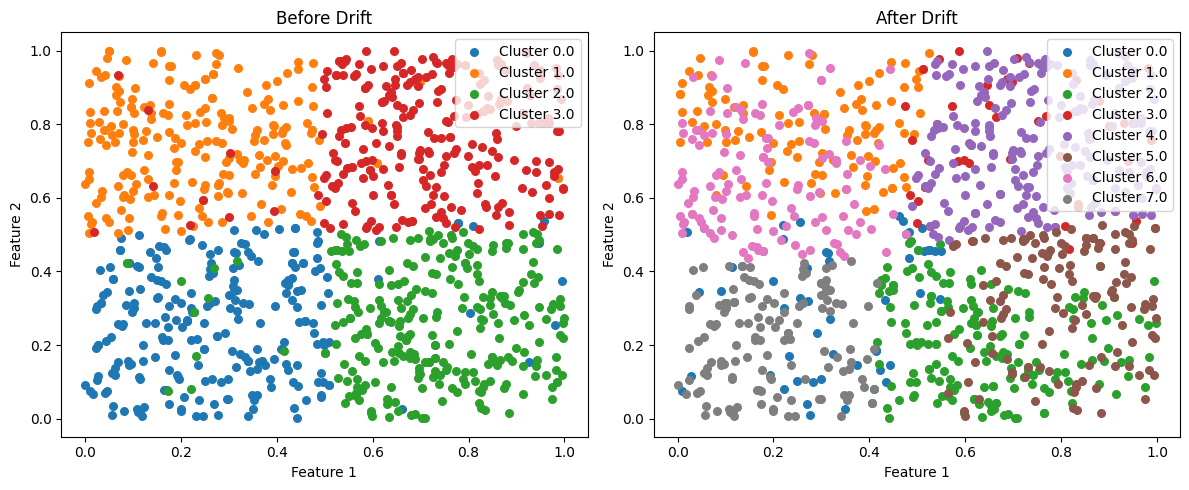

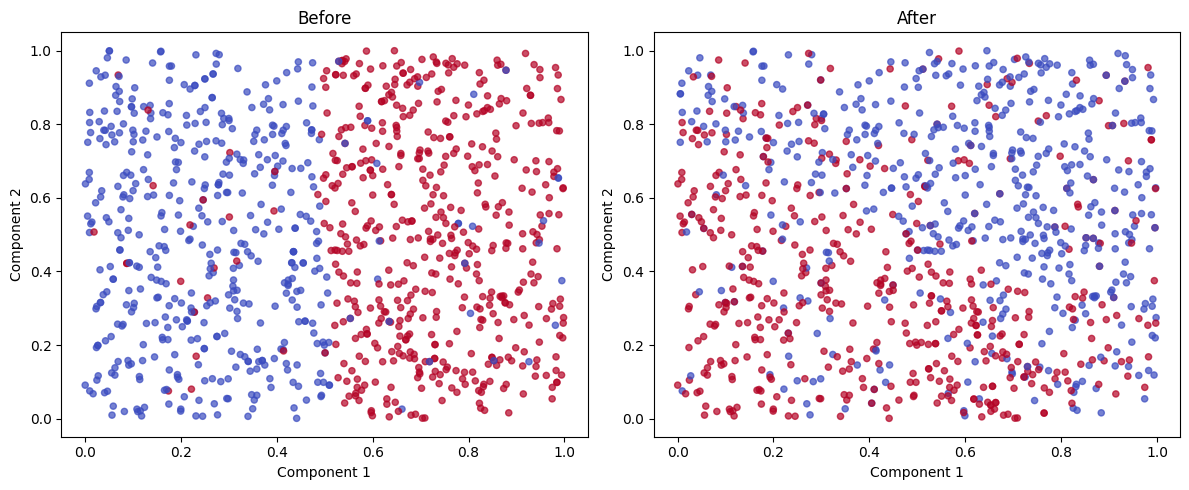

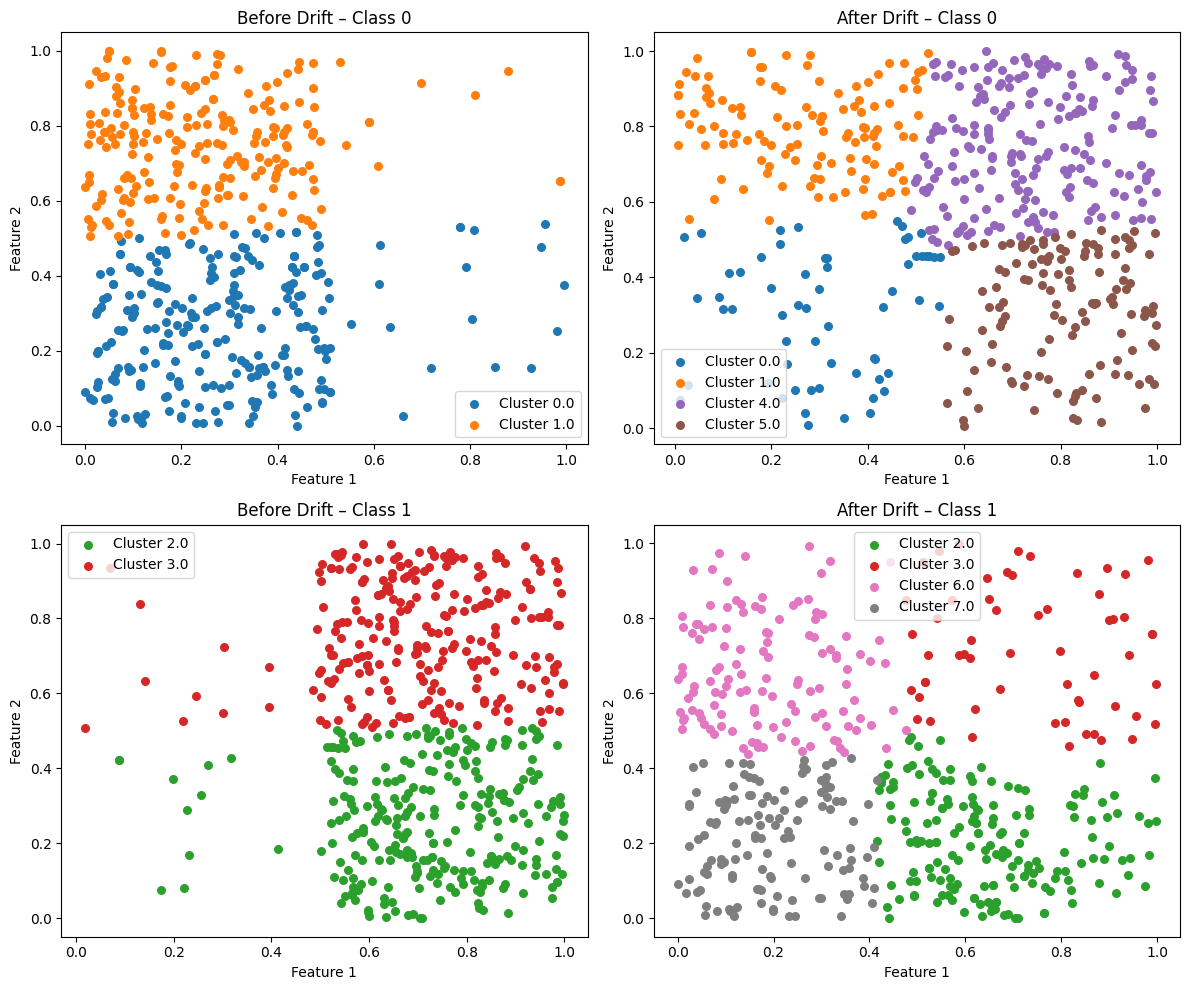

In [64]:
plot_drift_clustered(X_old[mask1_b].values, X_new[mask1_a].values, labels_old, labels_new)
plot_drift(X_old[mask1_b].values, y_old[mask1_b], X_new[mask1_a].values, y_new[mask1_a])

plot_clusters_by_class(X_old[mask1_b].values, X_new[mask1_a].values, y_old[mask1_b], y_new[mask1_a], labels_old, labels_new)

### **1. Hyperplane**

In [29]:
stream_Hyperplane = synth.Hyperplane(
    n_features=2,
    noise_percentage=0.0,
    mag_change=0.1,
    seed=42
)
n = 2000

X, y = transform_dict_to_list(stream_Hyperplane, n)

data_before = np.array(X[:n//2]), np.array(y[:n//2])
data_after = np.array(X[n//2:]), np.array(y[n//2:])

CBDD = ClusterBasedDriftDetector(data_before, data_after)
drift, details = CBDD.detect(thr_centroid_shift=0.01)

details

{0: {'nr_of_clusters': True, 'centroid_shift': True},
 1: {'nr_of_clusters': True, 'centroid_shift': True}}

In [30]:
labels_old = CBDD.cluster_labels_old
labels_new = CBDD.cluster_labels_new

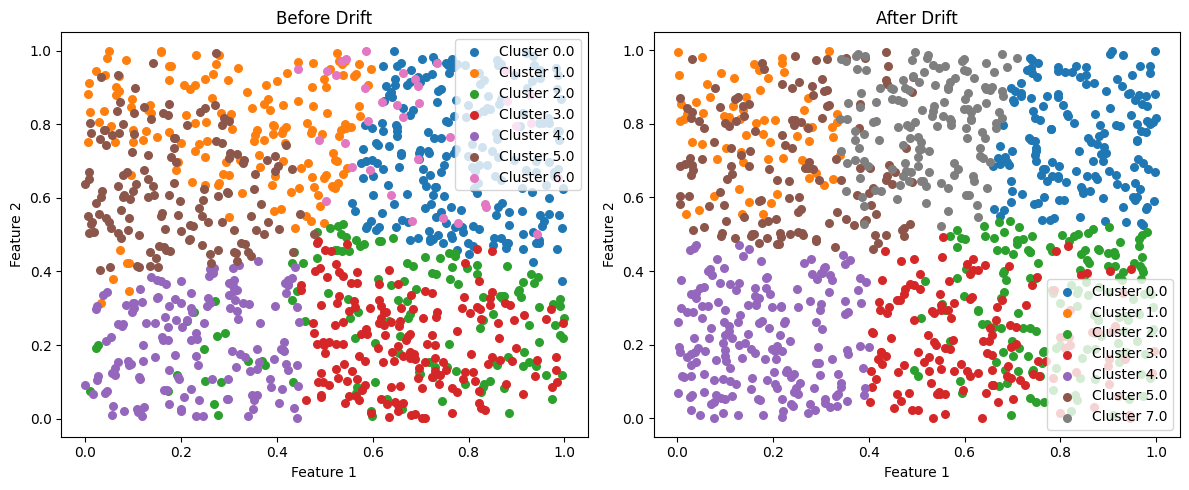

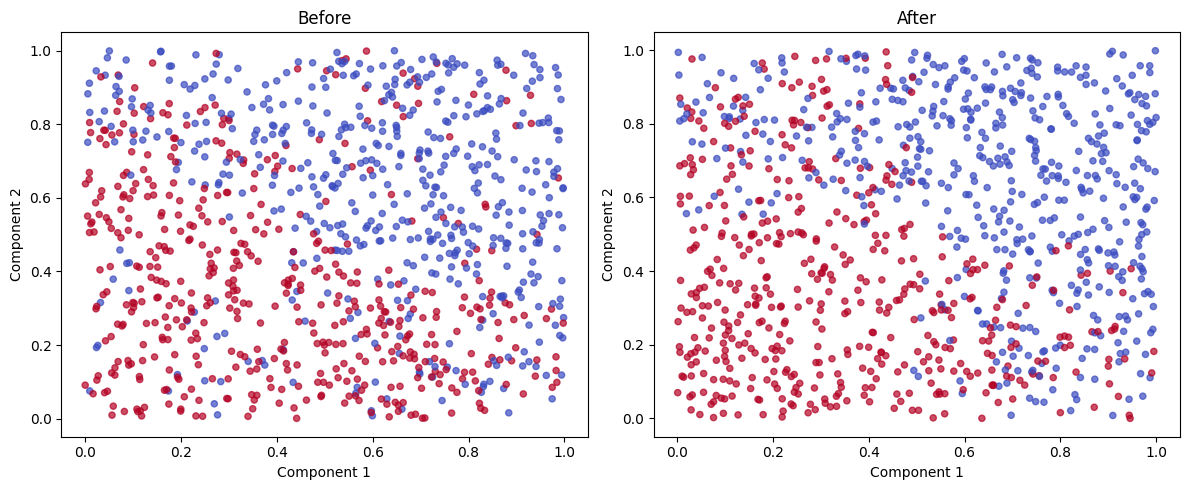

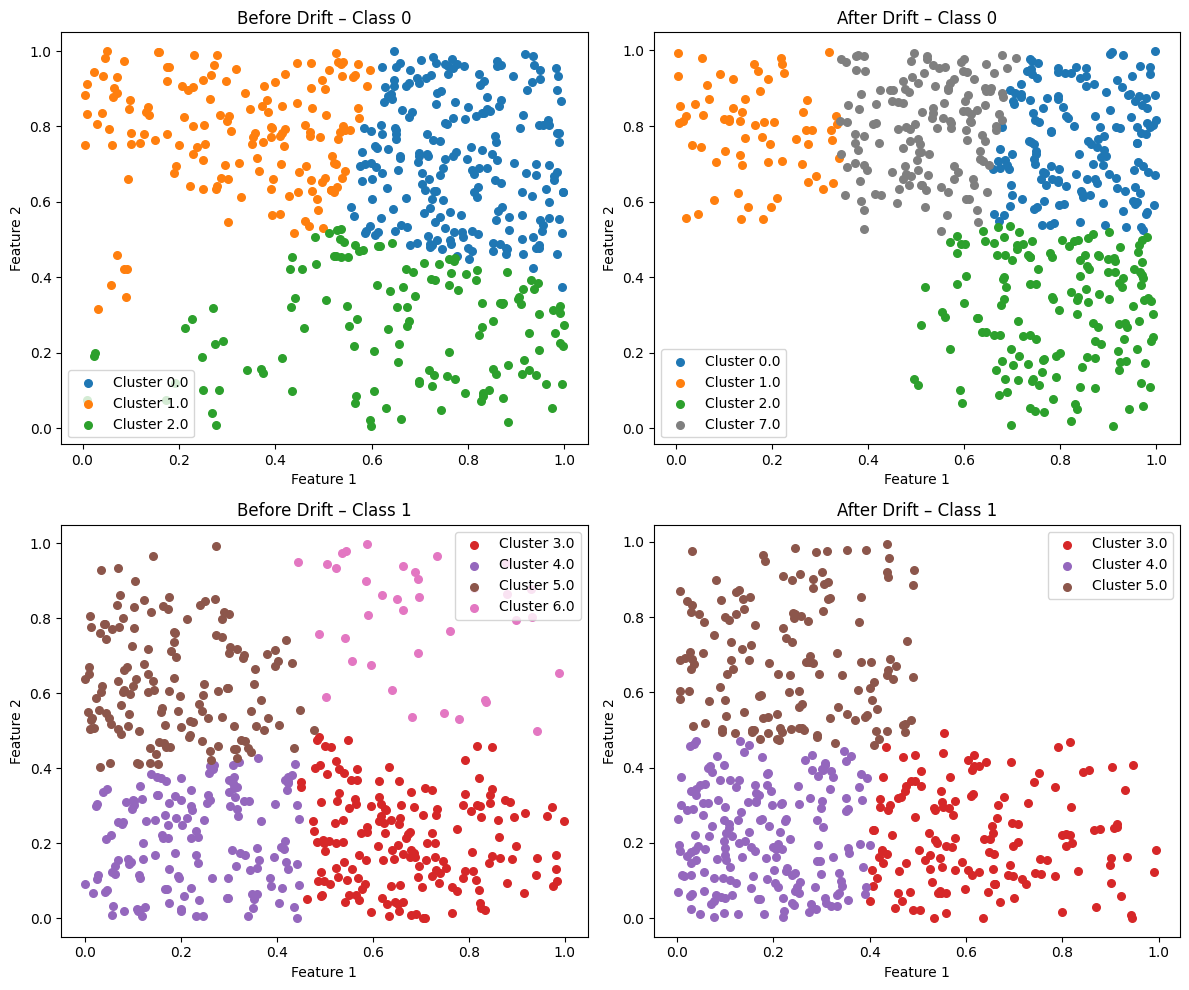

In [31]:
X_before, y_before = data_before
X_after, y_after = data_after

plot_drift_clustered(X_before, X_after, labels_old, labels_new)
plot_drift(X_before, y_before, X_after, y_after)

plot_clusters_by_class(X_before, X_after, y_before, y_after, labels_old, labels_new)

### **2. SEA - all features**

In [32]:
stream_SEA = synth.ConceptDriftStream(
    stream=synth.SEA(seed=42, variant=0),
    drift_stream=synth.SEA(seed=42, variant=3),
    position=500,
    width=10,
    seed=1
)
n = 1000

X, y = transform_dict_to_list(stream_SEA, n)

data_before = np.array(X[:n//2]), np.array(y[:n//2])
data_after = np.array(X[n//2:]), np.array(y[n//2:])

CBDD = ClusterBasedDriftDetector(data_before, data_after)
drift, details = CBDD.detect()

In [33]:
X_before, y_before = data_before
X_after, y_after = data_after

plot_drift_clustered(X_before, X_after, clusters_old, clusters_new)
plot_drift(X_before, y_before, X_after, y_after)
plot_clusters_by_class(X_before, X_after, y_before, y_after, clusters_old, clusters_new)

NameError: name 'clusters_old' is not defined

### **3. SEA but only with informative features**

In [ ]:
stream_SEA = synth.ConceptDriftStream(
    stream=synth.SEA(seed=42, variant=0),
    drift_stream=synth.SEA(seed=42, variant=3),
    position=500,
    width=10,
    seed=1
)
n = 1000

X, y = transform_dict_to_list(stream_SEA, n)
X = np.array(X)[:, :2]  # use only first two features for visualization

data_before = np.array(X[:n//2]), np.array(y[:n//2])
data_after = np.array(X[n//2:]), np.array(y[n//2:])

CBDD = ClusterBasedDriftDetector()
drift, details, clusters_old, clusters_new = CBDD.detect(data_before, data_after)

{1: 0, 0: 1} [] []
{1: 0, 0: 1} [] []


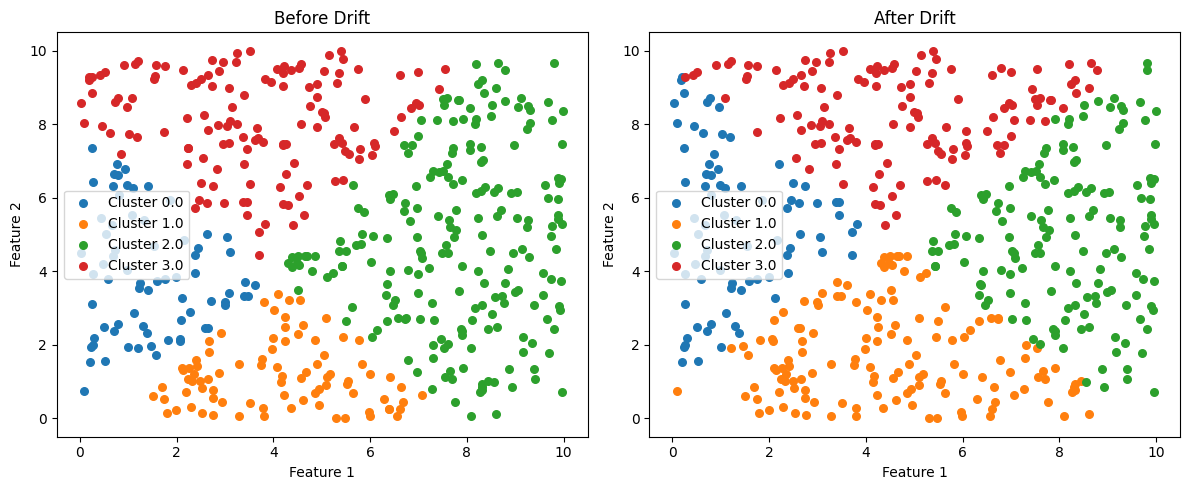

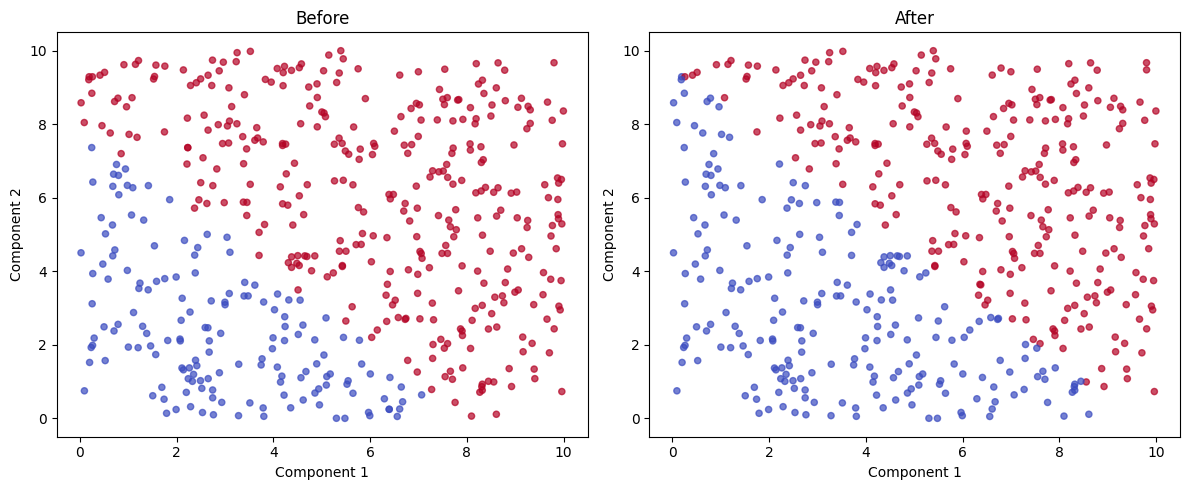

In [ ]:
X_before, y_before = data_before
X_after, y_after = data_after

plot_drift_clustered(X_before, X_after, clusters_old, clusters_new)
plot_drift(X_before, y_before, X_after, y_after)
# plot_final_comparison(X_before, X_after, y_before, y_after, clusters_old, clusters_new)

### **4. RBF**

In [ ]:
stream_RBF = synth.ConceptDriftStream(
    stream=synth.RandomRBF(n_features=2),
    drift_stream=synth.RandomRBF(n_features=2),
    position=500,
    width=10,
    seed=1
)
n = 1000

X, y = transform_dict_to_list(stream_RBF, n)
X = np.array(X)

data_before = np.array(X[:n//2]), np.array(y[:n//2])
data_after = np.array(X[n//2:]), np.array(y[n//2:])

CBDD = ClusterBasedDriftDetector()
drift, details, clusters_old, clusters_new = CBDD.detect(data_before, data_after)

{0: 0, 1: 1} [] []
{0: 0, 1: 1} [] []


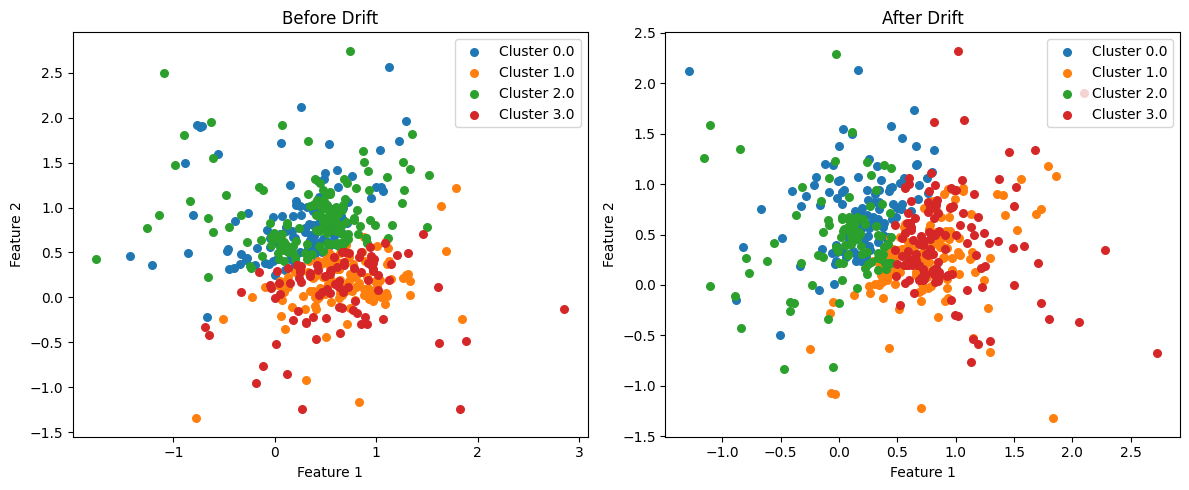

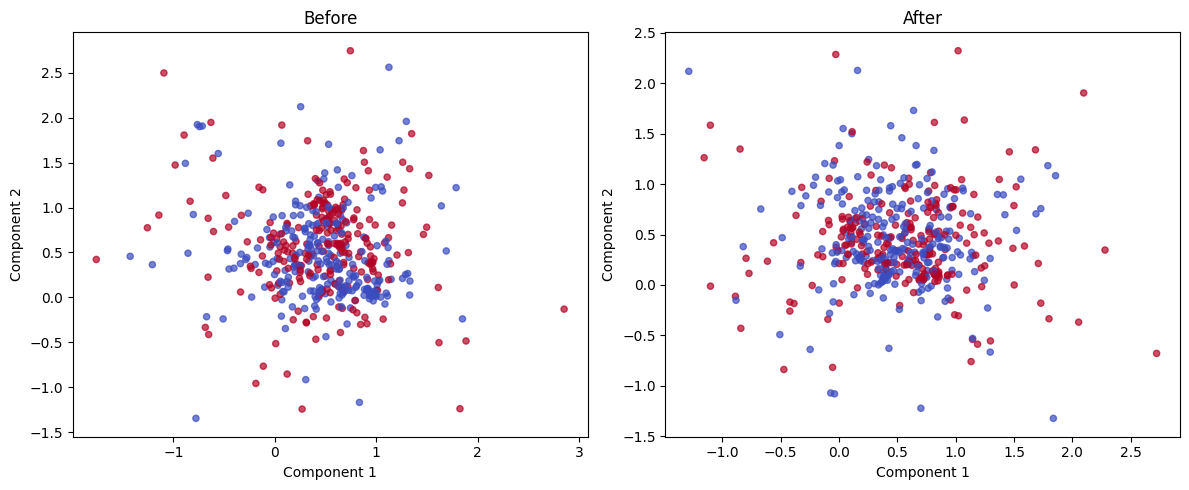

In [ ]:
X_before, y_before = data_before
X_after, y_after = data_after

plot_drift_clustered(X_before, X_after, clusters_old, clusters_new)
plot_drift(X_before, y_before, X_after, y_after)
# plot_final_comparison(X_before, X_after, y_before, y_after, clusters_old, clusters_new)

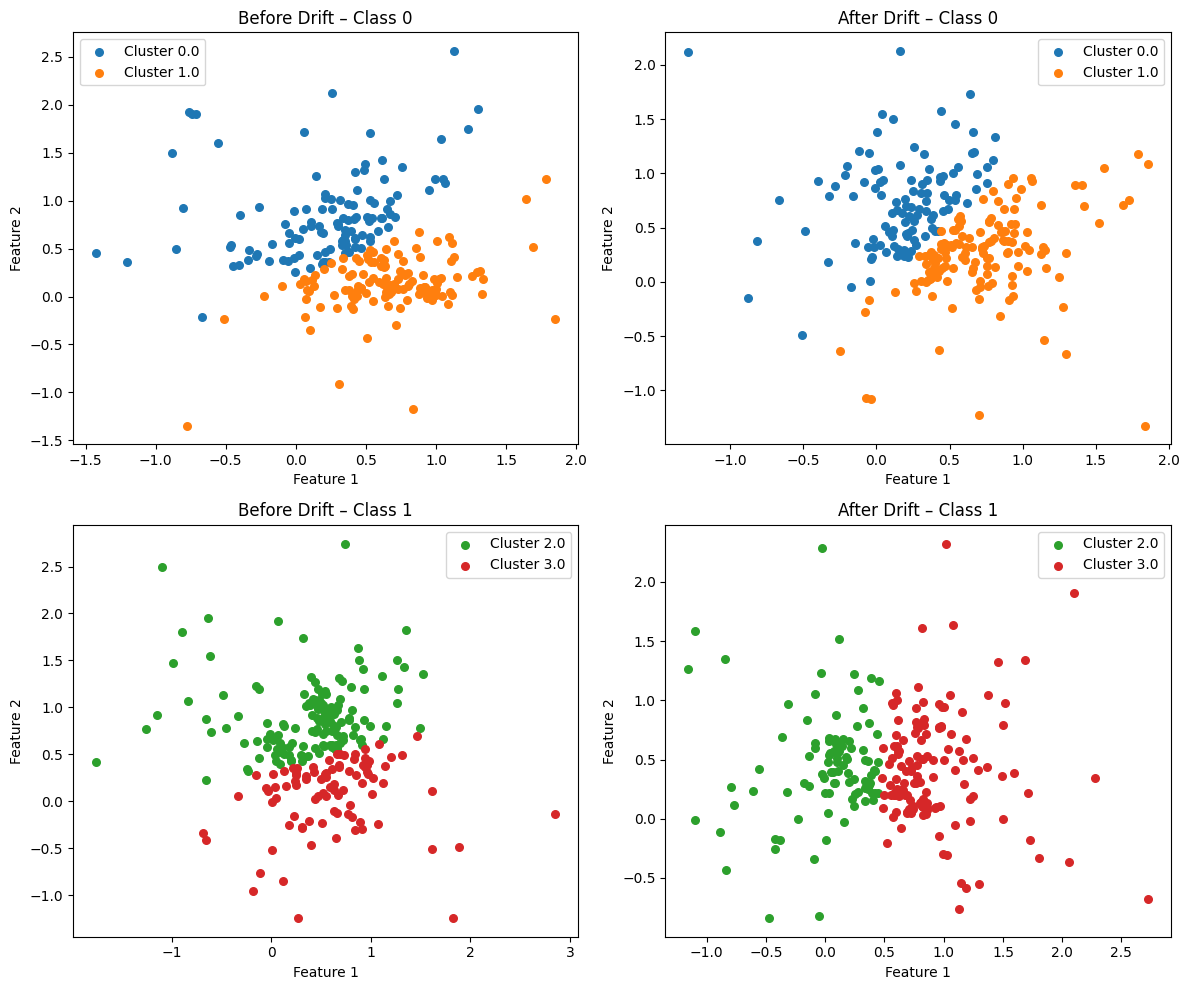

In [ ]:
plot_clusters_by_class(X_before, X_after, y_before, y_after, clusters_old, clusters_new)

In [ ]:
# mask0 = y_before == 0 # niebieski
# mask1 = y_before == 1 # czerwony

# mask_after0 = y_after == 0
# mask_after1 = y_after == 1

# for m_b, m_a in [(mask0, mask_after0), (mask1, mask_after1)]:
#     plot_drift_clustered(X_before[m_b], X_after[m_a], clusters_old[m_b], clusters_new[m_a])

## **7. Model training and drift detection with ADWIN** ##

In [ ]:
# TODO

In [ ]:
n = 1000
X, y = [], []

for x, label in stream_SEA.take(n):
    X.append([x[i] for i in x.keys()])
    y.append(label)

Drift detected at sample 511


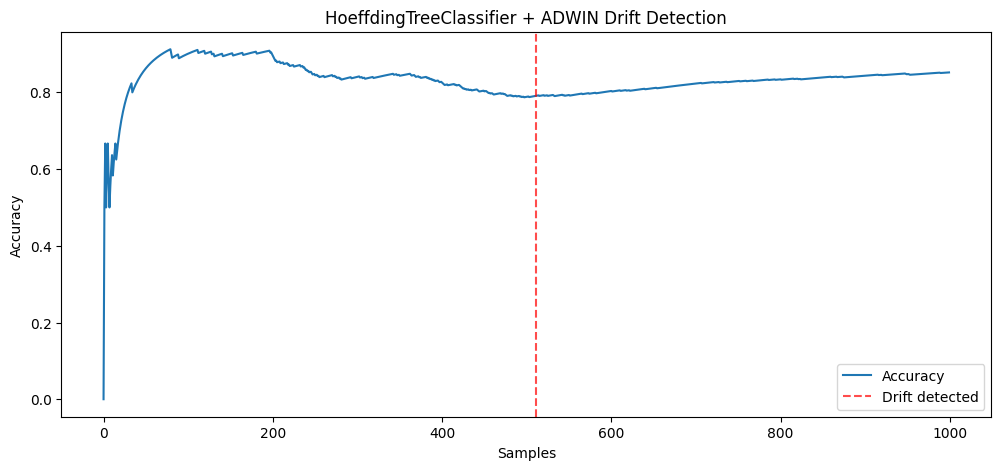

In [ ]:
adwin = ADWIN()
model = tree.HoeffdingTreeClassifier()
metric = metrics.Accuracy()

accuracies = []
drift_points = []

for i, (x, y) in enumerate(stream_Hyperplane.take(n)):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

    metric.update(y, y_pred)
    accuracies.append(metric.get())

    error = int(y_pred is not None and y != y_pred)
    adwin.update(error)

    if adwin.drift_detected:
        drift_points.append(i)
        print(f"Drift detected at sample {i}")

# 6. Plot results
plt.figure(figsize=(12,5))
plt.plot(accuracies, label="Accuracy")
for dp in drift_points:
    plt.axvline(dp, color="red", linestyle="--", alpha=0.7, label="Drift detected" if dp == drift_points[0] else "")
plt.xlabel("Samples")
plt.ylabel("Accuracy")
plt.title("HoeffdingTreeClassifier + ADWIN Drift Detection")
plt.legend()
plt.show()

To jest tak na szybko robione. Trzeba tak zrobic zeby dzialalo tez dla SEA